In [581]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

import re  
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [582]:
df = pd.read_csv('../data/nlp_iphones_cleaned.csv')

In [583]:
df = df.drop(columns=['Unnamed: 0', 'title'])

In [584]:
df

,price,condition,condition_description,num_reviews,pos_feedback_pct,return_days,model,capacity,release_year
0,135.99,1.0,“fully functional in excellent condition. our ...,30474.0,99.9,2.0,8,57.492355,2015
1,149.99,1.0,“overall good condition will have marks and sc...,13110.0,96.2,2.0,11,64.000000,2017
2,259.00,4.0,““pick your carrier or pick fully unlocked to ...,61033.0,100.0,2.0,11,256.000000,2017
3,107.99,1.0,“overall good working condition and will have ...,13110.0,96.2,2.0,10,32.000000,2016
4,209.95,3.0,"“this is a b+ stock item, meaning unit is in v...",332402.0,98.4,3.0,12,64.000000,2017
...,...,...,...,...,...,...,...,...,...
4141,456.99,3.0,“device is 100% fully functional and in very g...,54837.0,99.4,3.0,15,64.000000,2019
4142,335.00,1.0,“near mint condition: screen is 100% flawless....,22050.0,99.6,3.0,15,128.000000,2019
4143,591.00,1.0,“this is a used device with real photos of the...,80257.0,99.7,2.0,15,512.000000,2019
4144,149.99,1.0,“this device powers on and is 100% functional ...,4258.0,99.8,2.0,10,128.000000,2016


In [585]:
def process_description(description, min_length):
    stop_words = stopwords.words('english')

    wnl = WordNetLemmatizer()

    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    description_lower = description.lower()
    description_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", description_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")

    description_norm = [x for x in word_tokenize(description_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(description_norm))) 

    if len(wordnet_tagged) <= min_length:
        return ''
    else:
        # rejoins lemmatized sentence 
        description_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return description_norm

In [586]:
df['condition_description'] = df['condition_description'].apply(process_description, args=[5])
# df['title'] = df['title'].apply(process_description, args=[5])

In [587]:
df

,price,condition,condition_description,num_reviews,pos_feedback_pct,return_days,model,capacity,release_year
0,135.99,1.0,fully functional excellent condition device pr...,30474.0,99.9,2.0,8,57.492355,2015
1,149.99,1.0,overall good condition mark scratch mfi charge...,13110.0,96.2,2.0,11,64.000000,2017
2,259.00,4.0,pick carrier pick fully unlocked work multiple...,61033.0,100.0,2.0,11,256.000000,2017
3,107.99,1.0,overall good work condition mark scratch charg...,13110.0,96.2,2.0,10,32.000000,2016
4,209.95,3.0,stock item mean unit good cosmetic condition m...,332402.0,98.4,3.0,12,64.000000,2017
...,...,...,...,...,...,...,...,...,...
4141,456.99,3.0,device fully functional good physical conditio...,54837.0,99.4,3.0,15,64.000000,2019
4142,335.00,1.0,mint condition screen flawless wear frame negl...,22050.0,99.6,3.0,15,128.000000,2019
4143,591.00,1.0,use device real photo exact unique item actual...,80257.0,99.7,2.0,15,512.000000,2019
4144,149.99,1.0,device power functional ready use condition no...,4258.0,99.8,2.0,10,128.000000,2016


In [588]:
sia = SentimentIntensityAnalyzer()

In [589]:
# no data leakage. using pretrained model.
sia.polarity_scores(df['condition_description'][0])

{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'compound': 0.7251}

In [590]:
polarity_list = []
for row in df['condition_description']:
    polarity_list.append(sia.polarity_scores(row))

condition_polarity = pd.DataFrame(polarity_list)
condition_polarity.rename(columns={'neg':'condition_neg', 'neu':'condition_neu', 'pos':'condition_pos', 'compound':'condition_compound'}, inplace=True)

In [591]:
condition_polarity

,condition_neg,condition_neu,condition_pos,condition_compound
0,0.0,0.681,0.319,0.7251
1,0.0,0.707,0.293,0.4404
2,0.0,0.765,0.235,0.8360
3,0.0,0.707,0.293,0.4404
4,0.0,0.775,0.225,0.4404
...,...,...,...,...
4141,0.0,0.826,0.174,0.6682
4142,0.0,0.645,0.355,0.5106
4143,0.0,0.732,0.268,0.8357
4144,0.0,0.745,0.255,0.5859


In [592]:
# polarity_list = []
# for row in df['title']:
#     polarity_list.append(sia.polarity_scores(row))

# title_polarity = pd.DataFrame(polarity_list)
# title_polarity.rename(columns={'neg':'title_neg', 'neu':'title_neu', 'pos':'title_pos', 'compound':'title_compound'}, inplace=True)

In [593]:
# polarity_df = pd.merge(condition_polarity, title_polarity, left_index=True, right_index=True)
polarity_df = condition_polarity

In [594]:
df = pd.merge(df, polarity_df, left_index=True, right_index=True)

<AxesSubplot:>

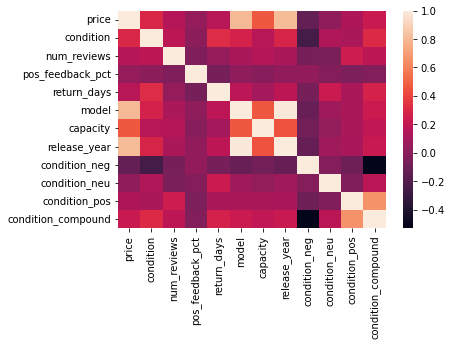

In [595]:
sns.heatmap(df.corr())

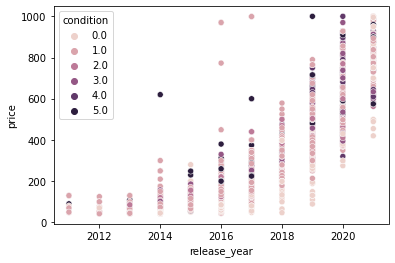

In [661]:
sns.scatterplot(y='price', x='release_year', hue='condition', data=df)
plt.show()

In [597]:
# sns.pairplot(hue='model', data=df)

(array([1176., 1139.,  903.,  369.,  185.,  123.,   74.,   72.,   63.,
          42.]),
 array([  1.   , 100.899, 200.798, 300.697, 400.596, 500.495, 600.394,
        700.293, 800.192, 900.091, 999.99 ]),
 <BarContainer object of 10 artists>)

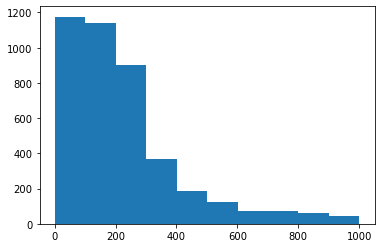

In [598]:
plt.hist(df['price'])

In [599]:
df = df[df['price']>40]

(array([1269., 1066.,  664.,  316.,  184.,   96.,   77.,   63.,   59.,
          42.]),
 array([ 40.5  , 136.449, 232.398, 328.347, 424.296, 520.245, 616.194,
        712.143, 808.092, 904.041, 999.99 ]),
 <BarContainer object of 10 artists>)

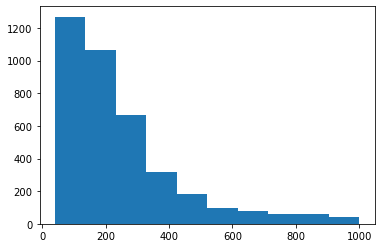

In [600]:
plt.hist(df['price'])

In [601]:
df.columns

Index(['price', 'condition', 'condition_description', 'num_reviews',
       'pos_feedback_pct', 'return_days', 'model', 'capacity', 'release_year',
       'condition_neg', 'condition_neu', 'condition_pos',
       'condition_compound'],
      dtype='object')

In [602]:
X = df.drop(columns = ['price', 'model'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=305)

In [603]:
# nlp_cols = 'condition_description'
# num_cols = ['num_reviews', 'pos_feedback_pct', 'capacity', 'condition_neg', 'condition_neu', 'condition_pos', 'condition_compound',
#        'title_neg', 'title_neu', 'title_pos', 'title_compound']
# cat_cols = ['condition', 'return_days', 'model', 'capacity', 'release_year']

In [604]:
nlp_cols = 'condition_description'
num_cols = ['num_reviews', 'pos_feedback_pct', 'capacity', 'condition_neg', 'condition_neu', 'condition_pos', 'condition_compound']
cat_cols = ['condition', 'return_days', 'capacity', 'release_year']

In [605]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))

In [606]:
tfidf.fit_transform(X_train['condition_description']).toarray().shape


(3452, 20782)

In [607]:
tfidf.get_feature_names()

['ab',
 'ab grade',
 'ab grade condition',
 'able',
 'able activated',
 'able activated clean',
 'able run',
 'able run screen',
 'abovecosmetic',
 'abovecosmetic condition',
 'abovecosmetic condition fair',
 'aboveincluded',
 'aboveincluded device',
 'aboveincluded device battery',
 'abrasion',
 'abrasion edge',
 'abrasion edge battery',
 'abrasion picture',
 'abrasion picture frame',
 'absolutely',
 'absolutely crack',
 'absolutely crack glass',
 'absolutely dent',
 'absolutely dent crack',
 'absolutely scratch',
 'absolutely scratch drop',
 'absolutely sign',
 'absolutely sign wear',
 'accept',
 'accept return',
 'accept return offer',
 'acceptable',
 'acceptable condition',
 'acceptable condition noticeable',
 'acceptable condition product',
 'acceptable rat',
 'acceptable rat product',
 'acceptable sign',
 'acceptable sign prior',
 'accepts',
 'accepts sim',
 'accepts sim card',
 'accessibility',
 'accessibility imei',
 'accessibility imei know',
 'accessory',
 'accessory charger'

In [608]:
class SentimentDataFramer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y = 0):
        return self
    def transform(self, data, y = 0):
        polarity_list = []
        polarity_list.extend(data.apply(self.sentiment))
        polarity_df = pd.DataFrame(polarity_list)
        return polarity_df
    def sentiment(self, desc):
        sia = SentimentIntensityAnalyzer()
        scores = sia.polarity_scores(desc)
        return scores

In [609]:
transformer_list = [
    ('nlpvect', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))),
    ('sentint', SentimentDataFramer())
]

feat_union = FeatureUnion(transformer_list)

In [610]:
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

categoric_pipeline = Pipeline([('ordnorm', StandardScaler())])

nlp_pipeline = Pipeline([('nlp', feat_union)])

In [611]:
ct = ColumnTransformer(
    [ ("nlppipeline", nlp_pipeline, nlp_cols),
      ("numericpipe", numeric_pipeline, num_cols),
      ("categoricpipeline", categoric_pipeline, cat_cols)
    ]
)

In [612]:
ct

ColumnTransformer(transformers=[('nlppipeline',
                                 Pipeline(steps=[('nlp',
                                                  FeatureUnion(transformer_list=[('nlpvect',
                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                               3),
                                                                                                  stop_words='english')),
                                                                                 ('sentint',
                                                                                  SentimentDataFramer())]))]),
                                 'condition_description'),
                                ('numericpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 ['num_reviews', 'pos_feedback_pct', 'capacity',
                                  'condition_neg', 'condition_neu',
                                  'condition_pos', 'condition_compound']),
                                ('categoricpipeline',
                                 Pipeline(steps=[('ordnorm',
                                                  StandardScaler())]),
                                 ['condition', 'return_days', 'capacity',
                                  'release_year'])])

In [613]:
set_config(display="diagram")

In [614]:
final_pipe = Pipeline([('preprocess', ct),
                      ('model', GradientBoostingRegressor())])
final_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nlppipeline',
                                                  Pipeline(steps=[('nlp',
                                                                   FeatureUnion(transformer_list=[('nlpvect',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                3),
                                                                                                                   stop_words='english')),
                                                                                                  ('sentint',
                                                                                                   SentimentDataFramer())]))]),
                                                  'condition_description'),
                                                 ('numericpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  ['num_reviews',
                                                   'pos_feedback_pct',
                                                   'capacity', 'condition_neg',
                                                   'condition_neu',
                                                   'condition_pos',
                                                   'condition_compound']),
                                                 ('categoricpipeline',
                                                  Pipeline(steps=[('ordnorm',
                                                                   StandardScaler())]),
                                                  ['condition', 'return_days',
                                                   'capacity',
                                                   'release_year'])])),
                ('model', GradientBoostingRegressor())])

In [615]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nlppipeline',
                                                  Pipeline(steps=[('nlp',
                                                                   FeatureUnion(transformer_list=[('nlpvect',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                3),
                                                                                                                   stop_words='english')),
                                                                                                  ('sentint',
                                                                                                   SentimentDataFramer())]))]),
                                                  'condition_description'),
                                                 ('numericpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  ['num_reviews',
                                                   'pos_feedback_pct',
                                                   'capacity', 'condition_neg',
                                                   'condition_neu',
                                                   'condition_pos',
                                                   'condition_compound']),
                                                 ('categoricpipeline',
                                                  Pipeline(steps=[('ordnorm',
                                                                   StandardScaler())]),
                                                  ['condition', 'return_days',
                                                   'capacity',
                                                   'release_year'])])),
                ('model', GradientBoostingRegressor())])

In [616]:
y_pred = final_pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print('RMSE: '+str(rmse))
print('R-Squared: '+str(r_squared))

RMSE: 60.31036431698695
R-Squared: 0.895742842947155


In [617]:
param_grid = {'model__n_estimators' : [500],
              'model__max_depth' : range(5,10),
              'model__min_samples_split' : [2, 3, 4, 5, 6, 7],
              'model__learning_rate' : [0.01, 0.02, 0.03],
              'model__subsample': [0.9, 0.5, 0.2, 0.1]
              }

In [618]:
# grid_GBR = GridSearchCV(estimator=final_pipe, param_grid = param_grid, cv = 2, n_jobs=-1)
# grid_GBR.fit(X_train, y_train)

    

In [619]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
# print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
# print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [620]:
params = {
    "n_estimators": 500,
    "max_depth": 9,
    "min_samples_split": 7,
    "learning_rate": 0.02,
    "loss": 'lad',
    "subsample":0.5
}

best_xgboost = GradientBoostingRegressor(**params)

In [621]:
gs_pipe = Pipeline([('preprocess', ct),
                      ('model', best_xgboost)])
gs_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nlppipeline',
                                                  Pipeline(steps=[('nlp',
                                                                   FeatureUnion(transformer_list=[('nlpvect',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                3),
                                                                                                                   stop_words='english')),
                                                                                                  ('sentint',
                                                                                                   SentimentDataFramer())]))]),
                                                  'condition_description'),
                                                 ('numericpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  ['num_reviews',
                                                   'pos_feedback_pct',
                                                   'capacity', 'condition_neg',
                                                   'condition_neu',
                                                   'condition_pos',
                                                   'condition_compound']),
                                                 ('categoricpipeline',
                                                  Pipeline(steps=[('ordnorm',
                                                                   StandardScaler())]),
                                                  ['condition', 'return_days',
                                                   'capacity',
                                                   'release_year'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.02, loss='lad',
                                           max_depth=9, min_samples_split=7,
                                           n_estimators=500, subsample=0.5))])

In [622]:
gs_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nlppipeline',
                                                  Pipeline(steps=[('nlp',
                                                                   FeatureUnion(transformer_list=[('nlpvect',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                3),
                                                                                                                   stop_words='english')),
                                                                                                  ('sentint',
                                                                                                   SentimentDataFramer())]))]),
                                                  'condition_description'),
                                                 ('numericpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  ['num_reviews',
                                                   'pos_feedback_pct',
                                                   'capacity', 'condition_neg',
                                                   'condition_neu',
                                                   'condition_pos',
                                                   'condition_compound']),
                                                 ('categoricpipeline',
                                                  Pipeline(steps=[('ordnorm',
                                                                   StandardScaler())]),
                                                  ['condition', 'return_days',
                                                   'capacity',
                                                   'release_year'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.02, loss='lad',
                                           max_depth=9, min_samples_split=7,
                                           n_estimators=500, subsample=0.5))])

In [623]:
y_pred = gs_pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print('RMSE: '+str(rmse))
print('R-Squared: '+str(r_squared))

RMSE: 55.550763286626804
R-Squared: 0.911549144933534


In [624]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import warnings
warnings.filterwarnings('ignore')

In [625]:
w_feedbackpctg = widgets.FloatSlider(
    value=90,
    min=70.0,
    max=100.0,
    step=0.1,
    description='Positive Feedback Percentage:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

In [626]:
w_feedbackpctg

FloatSlider(value=90.0, continuous_update=False, description='Positive Feedback Percentage:', min=70.0, orient…

In [627]:
w_condition = widgets.Dropdown(
    options=['Broken or For Parts', 'Used', 'Good - Refurbished', 'Very Good - Refurbished', 'Excellent - Refurbished', 'Open Box', 'New'],
    value='Good - Refurbished',
    description='Condition: ',
    disabled=False,
)

In [628]:
w_condition

Dropdown(description='Condition: ', index=2, options=('Broken or For Parts', 'Used', 'Good - Refurbished', 'Ve…

In [629]:
condition_dict = {
    'for parts or not working': 0,
    'used': 1,
    'good - refurbished': 2,
    'very good - refurbished': 3,
    'excellent - refurbished': 4,
    'open box': 5,
    'new': 6
}

In [630]:
w_capacity = widgets.Dropdown(
    options=['16 GB', '32 GB', '64 GB', '128 GB', '256 GB', '512 GB'],
    value='64 GB',
    description='Capacity: ',
    disabled=False,
)

In [631]:
w_capacity

Dropdown(description='Capacity: ', index=2, options=('16 GB', '32 GB', '64 GB', '128 GB', '256 GB', '512 GB'),…

In [632]:
float(re.findall('[0-9]+', w_capacity.value)[0])

64.0

In [633]:
w_condition_description = widgets.Textarea(
    value='',
    placeholder='Type description',
    description='Description:',
    disabled=False
)

In [634]:
w_condition_description

Textarea(value='', description='Description:', placeholder='Type description')

In [635]:
w_num_reviews = widgets.Text( 
    value='',
    placeholder='Type number of reviews',
    description='# Reviews:',
    disabled=False
)

In [636]:
w_num_reviews

Text(value='', description='# Reviews:', placeholder='Type number of reviews')

In [637]:
w_return_days = widgets.Dropdown(
    options=['Seller does not accept returns', '14 days returns', '30 days returns', '60 days returns'],
    value='14 days returns',
    description='Returns: ',
    disabled=False,
)

In [638]:
w_return_days

Dropdown(description='Returns: ', index=1, options=('Seller does not accept returns', '14 days returns', '30 d…

In [639]:
return_dict = {
    'Seller does not accept returns': 0,
    '14 days returns': 1,
    '30 days returns': 2,
    '60 days returns': 3
}

In [640]:
w_release_year = widgets.Text( 
    value='',
    placeholder='Type Release Year',
    description='Release Yr:',
    disabled=False
)

In [641]:
w_release_year

Text(value='', description='Release Yr:', placeholder='Type Release Year')

In [662]:
@interact
def show_widgets(a = w_feedbackpctg,b = w_capacity,c= w_condition,d= w_condition_description,e= w_num_reviews,f= w_return_days,g= w_release_year):
    


    sample_dict = {
        'pos_feedback_pct':a,
        'capacity':b,
        'condition':c,
        'condition_description':d,
        'num_reviews':e,
        'return_days':f,
        'release_year':g
    }
    series = pd.Series(sample_dict)


    return series

interactive(children=(FloatSlider(value=90.0, continuous_update=False, description='Positive Feedback Percenta…

In [647]:
gs_pipe.predict(X_test.iloc[0].array)

IndexError: tuple index out of range

In [576]:
X_test.iloc[0]

condition                                                              4.0
condition_description    device come excellent physical condition scree...
num_reviews                                                        54835.0
pos_feedback_pct                                                      99.4
return_days                                                            3.0
capacity                                                         69.467626
release_year                                                          2016
condition_neg                                                        0.033
condition_neu                                                        0.826
condition_pos                                                        0.141
condition_compound                                                  0.8126
Name: 1762, dtype: object